## standardize to football field in meters

The data is in meters from tracking-produced. It is like this:


![alt text](sphx_glr_plot_pitch_types_009.png "Title")

meaning that the standardization we need to make is to "flip the values" and make them numerical 

In [1]:
from scipy.stats import gaussian_kde
from mplsoccer import Standardizer
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import xml.etree.ElementTree as ET
import pandas as pd
import ast
import uuid

# Parse xml file

In [4]:
def parse_tracking_xml(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Generate a single unique ID for the entire dataset
    unique_id = str("viborg")

    # List to store extracted data
    data = []

    # Iterate over periods
    for period in root.findall('period'):
        period_number = int(period.get('number'))

        # Iterate over frames
        for frame in period.findall('frame'):
            timestamp = float(frame.get('time'))

            # Iterate over players
            for player in frame.findall('player'):
                player_num = int(player.get('num'))
                loc = ast.literal_eval(player.get('loc'))  # Convert string to list of floats
                spd = float(player.get('spd'))  # Extract speed
                player_id = str(player.get("id"))

                # Append to data list
                data.append({
                    'unique_id': unique_id,  
                    'period': period_number,
                    'time': timestamp,
                    'player_id':player_id,
                    'player_num': player_num,
                    'x': round(loc[0] + 53, 2), 
                    'y': round(loc[1] + 34, 2),
                    'z': loc[2],
                    'spd': spd
                })

    return data

# Example usage
xml_file = "/Users/annadaugaard/Desktop/VFF/tracking-produced.xml"  # Replace with actual file path
tracking_data = parse_tracking_xml(xml_file)

# Convert to DataFrame
df = pd.DataFrame(tracking_data)

df.to_csv("viborg_players_tracking.csv")

In [6]:
import xml.etree.ElementTree as ET
import pandas as pd
import xml.etree.ElementTree as ET
import pandas as pd
import xml.etree.ElementTree as ET
import pandas as pd

def extract_ball_csv_from_xml(xml_filename, csv_filename):
    """
    Extracts the ball's location, frame time, and period from an XML tracking file and
    saves a CSV file with columns: index, time, ball_x, ball_y, period.
    
    The function expects each <period> element to have a "number" attribute and 
    each <frame> element to have a "time" attribute and contain a <ball> element with 
    a "loc" attribute formatted as "[x, y, z]".
    
    Parameters:
      xml_filename (str): Path to the input XML file.
      csv_filename (str): Path to save the output CSV file.
    """
    try:
        tree = ET.parse(xml_filename)
    except ET.ParseError as e:
        print("Error parsing XML:", e)
        return
    root = tree.getroot()
    
    # List to hold our data rows.
    rows = []
    
    # Iterate over each period element to capture its number.
    for period_elem in root.findall("period"):
        period_number = period_elem.get("number")
        # Iterate over all frame elements within this period.
        for frame in period_elem.findall("frame"):
            time_str = frame.get("time")
            if time_str is None:
                continue
            try:
                time_val = float(time_str)
            except ValueError:
                continue
            
            # Look for the <ball> element within this frame.
            ball_elem = frame.find("ball")
            if ball_elem is None:
                continue
            
            loc_str = ball_elem.get("loc")
            if loc_str is None:
                continue
            
            # Remove any surrounding brackets and split by comma.
            loc_str = loc_str.strip("[]")
            parts = loc_str.split(",")
            if len(parts) < 2:
                continue
            try:
                ball_x = float(parts[0].strip())
                ball_y = float(parts[1].strip())
            except ValueError:
                continue
            
            # Append a dictionary with time, ball coordinates, and period.
            rows.append({
                "time": time_val, 
                "ball_x": ball_x + 53,  # shifting if needed
                "ball_y": ball_y + 34,  # shifting if needed
                "period": period_number
            })
    
    if not rows:
        print("No ball data extracted from the XML file.")
        return
    
    # Create a DataFrame from the rows.
    df = pd.DataFrame(rows)
    # Convert period to integer so that sorting works numerically.
    df['period'] = df['period'].astype(int)
    # Sort by period and then by time.
    df = df.sort_values(["period", "time"]).reset_index(drop=True)
    
    # Save the DataFrame to CSV (with a serial index column if desired)
    df.to_csv(csv_filename, index_label="index", float_format="%.2f")
    print(f"Saved {len(df)} rows to {csv_filename}")

# Example usage:
if __name__ == "__main__":
    # Replace these with your actual file paths.
    xml_filename = "/Users/annadaugaard/Desktop/VFF/tracking-produced.xml"
    csv_filename = "ball_tracking_VFF.csv"
    extract_ball_csv_from_xml(xml_filename, csv_filename)



Saved 103719 rows to ball_tracking_VFF.csv


## Parse CSV file

In [2]:

def preprocess_data_csv(filepath, team):
  
    df_original = pd.read_csv(filepath, header=None)

    raw_ids = df_original.iloc[1, 3:31].tolist()  
    real_ids = [str(i) for i in raw_ids if not pd.isna(i)]  

    colnames = [f"{'x' if i % 2 == 0 else 'y'}{real_ids[i//2]}" for i in range(len(real_ids) * 2)]
    final_colnames = ['period', 'frame', 'time'] + colnames + ['ball_x', 'ball_y']
    df_original.columns = df_original.iloc[2]  
    df_original = df_original[3:].reset_index(drop=True)  
    df_original.columns = final_colnames[:len(df_original.columns)] 
    
    
    df_ball = df_original[['time', 'ball_x', 'ball_y']].copy()
    df_ball = df_ball.astype(float)
    df_ball['ball_x'] = round(df_ball['ball_x']*106,2)
    df_ball['ball_y'] = round(df_ball['ball_y']*68,2)
    
    id_vars = ['period', 'time', 'frame'] 
    value_vars = [col for col in df_original.columns if col not in id_vars]  

    df_long_corrected = pd.melt(df_original, id_vars=id_vars, var_name='variable', value_name='value')


    df_long_corrected.replace("", pd.NA, inplace=True)

    df_long_corrected['id'] = df_long_corrected['variable'].str.extract(r'(\d+)$')
    df_long_corrected['coordinate'] = df_long_corrected['variable'].str.extract(r'([xy])')

    df_wide_corrected = df_long_corrected.pivot_table(index=['period', 'frame', 'time', 'id'], 
                                                    columns='coordinate', 
                                                    values='value', 
                                                    aggfunc='first').reset_index()
    df_wide_corrected=df_wide_corrected.astype({'period': float, 'frame': float, 'time': float, 'x': float, 'y': float})

    df_wide_corrected['z'] = 0
    df_wide_corrected['Team'] = team

    # Renaming columns for clarity
    df_wide_corrected = df_wide_corrected.rename(columns={'x': 'x', 'y': 'y'})
    df_wide_corrected['x'] = round(df_wide_corrected['x']*106,2)
    df_wide_corrected['y'] = round(df_wide_corrected['y']*68,2)
    df_wide_corrected['time'] = pd.to_numeric(df_wide_corrected['time'], errors='coerce')
    df_wide_corrected = df_wide_corrected.sort_values(by=['time'], ascending=True).reset_index(drop=True)

    return df_wide_corrected, df_ball


In [3]:
away, df_ball_away = preprocess_data_csv("/Users/annadaugaard/Desktop/VFF/raw_data/sample_match_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "away")
home, df_ball_home = preprocess_data_csv("/Users/annadaugaard/Desktop/VFF/raw_data/sample_match_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "home")

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_70411/270152940.py:3: DtypeWarning: Columns (0,1,2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(filepath, header=None)


KeyboardInterrupt: 

In [64]:

df_ball_away.equals(df_ball_home)
df_ball_away.to_csv("labelled_match_ball.csv")

# Merging dataframes on 'time' with an outer join to ensure all values are retained
df_merged = pd.concat([away, home], ignore_index=False).sort_values(by="time")
df_merged.reset_index(drop=True, inplace=True)

df_merged.to_csv("labelled_match_players.csv")

## Plot ball movement on field

In [70]:
def plot_ball_data(x_relative, y_relative, field_length=105, field_width=68):

    # Compute density map of ball positions
    xy = np.vstack([x_relative, y_relative])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x_relative, y_relative, c=z, s=1, alpha=0.1, cmap='Greys')
    plt.plot([0, field_length, field_length, 0, 0], [0, 0, field_width, field_width, 0], 'r-', linewidth=2, label='Field Boundary')
    
    plt.grid(True)
    plt.xlabel('X Coordinate (meters)')
    plt.ylabel('Y Coordinate (meters)')
    plt.title('Ball Movement Analysis')
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

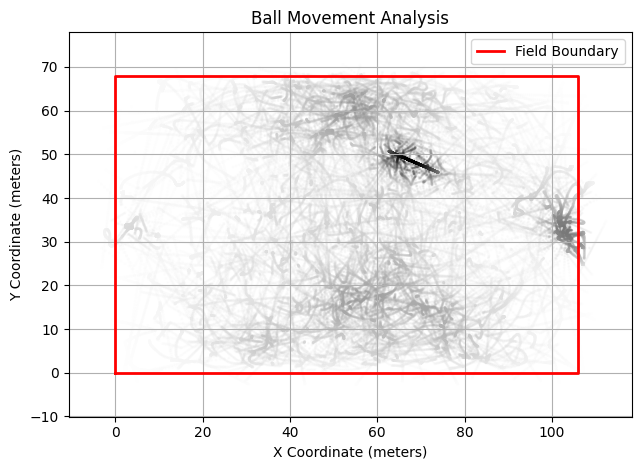

In [71]:
plot_ball_data(df_ball_away['ball_x'][~np.isnan(df_ball_away['ball_x'])], df_ball_away['ball_y'][~np.isnan(df_ball_away['ball_y'])],field_length=106, field_width=68)